In [8]:
# 라이브러리 불러오기
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split
 
#kobert
from kobert_tokenizer import KoBERTTokenizer

# transformers
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

# GPU 사용시 필요
device = torch.device("cuda:0")

In [9]:
# 모델 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = tokenizer.tokenize

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6, #클래스 수 조정
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
    
model = torch.load('model/kobert-v6.pt')

max_len = 64
batch_size = 32


class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         
    def __len__(self):
        return (len(self.labels))
    
def predict(sentence):
    dataset = [[sentence, '0']]
    test = BERTDataset(dataset, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=0)
    model.eval()
    answer = 0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        for logits in out:
            logits = logits.detach().cpu().numpy()
            answer = np.argmax(logits)
    return answer

In [12]:
emos = ('행복','불안','놀람', '슬픔','분노','중립')
def sa_demo(sentence):
    res = predict(sentence)
    print("문장에서 "+ emos[res] + "이(가) 느껴집니다.")

In [13]:
def getres(text):

    emos = ('행복','불안','놀람', '슬픔','분노','중립')
    res = {'행복':0,'불안':0,'놀람':0, '슬픔':0,'분노':0,'중립':0}

    for sentence in text:
        res[emos[predict(sentence)]] += 1
        
    return res

In [14]:
def getres_(text):

    emos = ('행복','불안','놀람', '슬픔','분노','중립')

    for sentence in text:
        
        res = emos[predict(sentence)]
        
        if res != '중립':
            print("{}    {}".format(res, sentence))
        

In [17]:
import re
import pandas as pd

# file_path ='data/성냥팔이_소녀.txt'
# file_path = 'data/셜록홈즈-공포의 오렌지씨앗_.txt'
file_path = 'data/흥부전_슬픔.txt'
file_path = 'data/[셜록홈즈]두번의_핏자국.txt'


file = open(file_path, 'r',encoding='UTF8')    #인코딩 안바꾸면 오류
raw_text = file.readlines()

#줄바꿈제거
textsum = '' 
for sentence in raw_text:
    sentence = sentence.replace("\n", "")
    textsum += sentence

#(한자) 제거    
textsum = re.sub('\([^)]*\)|[一-龥]', '', textsum)

textsum = textsum.replace('…', '...')

print(len(textsum))

#문장 단위로 분리: . ”로 끝날때마다 묶어주기
text = []
s, e = 0, 0
isopen = False #쌍따옴표 안에 글자인지 확인

for i in range(len(textsum)-1):
    if textsum[i]=='“':
        isopen = True
        continue
        
    if (textsum[i]=='.' and textsum[i+1]!='”' and isopen==False) or textsum[i]=='”':
        e = i+1
        text.append(textsum[s:e].strip())
        s = e
        isopen = False
        

res = getres(text)
res

23797


{'행복': 21, '불안': 11, '놀람': 27, '슬픔': 22, '분노': 18, '중립': 609}

In [15]:
# 테스트 감정 등장 순서

import re
import pandas as pd

file_path ='data/성냥팔이_소녀.txt'
file_path = 'data/빨간 모자.txt'
file_path = 'data/흥부전_슬픔.txt'
file_path = 'data/[셜록홈즈]두번의_핏자국.txt'


file = open(file_path, 'r',encoding='UTF8')    #인코딩 안바꾸면 오류
raw_text = file.readlines()

#줄바꿈제거
textsum = '' 
for sentence in raw_text:
    sentence = sentence.replace("\n", "")
    textsum += sentence

#(한자) 제거    
textsum = re.sub('\([^)]*\)|[一-龥]', '', textsum)

textsum = textsum.replace('…', '...')

print(len(textsum))

#문장 단위로 분리: . ”로 끝날때마다 묶어주기
text = []
s, e = 0, 0
isopen = False #쌍따옴표 안에 글자인지 확인

for i in range(len(textsum)-1):
    if textsum[i]=='“':
        isopen = True
        continue
        
    if (textsum[i]=='.' and textsum[i+1]!='”' and isopen==False) or textsum[i]=='”':
        e = i+1
        text.append(textsum[s:e].strip())
        s = e
        isopen = False
        
getres_(text)

23797
놀람    ?? 두번의 핏자국 ??                                        코난 도일  1.
행복    어느 해 가을의 화요일 아침,  전유럽에 이름을 떨치고 있는 인물 두 사람이 베이커가에 있는 우리의 검소한 하숙집을 찾아왔다.
불안    호프 장관은 신경질적으로 콧수염을 잡아 당기기도 하고, 시겟줄에 매달려 있는 도장집을 초조하게 매만지면서 말했다.
분노    "총리는 믿음직스럽다는 듯이 고개를 끄덕거렸다.
분노    그렇게까지 된 일을 몇 시간 뒤 내 자신이 그걸 잃어버리다니.
분노    "호프 장관은 단정하게 생긴 얼굴을 일그러뜨리며 양손으로 머리칼을 쥐어뜯었다.
놀람    총리는 시무룩한 얼굴을 하고서 짙은 눈썹을 찌푸렸다.
놀람    수신자 이름은 커다랗고 대담한 필적으로.
행복    "홈즈는 미소를 지으며 일어섰다.
분노    "총리는 벌떡 일어서서 장관들까지 쩔쩔매게 하는 그 매서운 눈초리로 홈즈를 노려보았다.
놀람    "이런 일은 처음이오.
행복    "홈즈는 종이에 이름을 적어 총리에게 보였다.
놀람    "맞소.
놀람    그런 편지가 이렇게 감쪽같이 없어지다니.
불안    ""만일 그 편지가 적의 손아귀에 들어갔다고 하면,우선 누구에게 보내게 될까요?""유럽의 총리라면 어느 누구에게라도 좋을 거요.
분노    "호프 장관은 고개를 떨어뜨리고 크게 신음소리를 냈다.
불안    "그 편지를 되찾지 못하면 정말로 전쟁이 일어난다고 생각하시나요?""그럴 위험성이 지극히 큽니다.
놀람    당신의 추리력은 정말 놀랍소.
놀람    홈즈는 잠자코 담배 파이프에 불을 붙이고서 잠시 생각에 잠겼다.
분노    내가 조간신문을 펴들고서 어제 저녁 런던 시내에서 일어난 범죄 기사 중 두드러진 것을 읽고 있는데, 홈즈는 무슨 소리를 외치더니 벌떡 일어나 파이프를 벽난로 위에 놓았다.
불안    지금부터라도 편지를 훔   친것이 누구라는 것만 확실히 알게되면 그 편지를 되찾을 수 있을지도 모르겠    네.
놀람    

In [8]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print(font_list)

['C:\\Windows\\Fonts\\seguisbi.ttf', 'C:\\Windows\\Fonts\\phagspab.ttf', 'C:\\Windows\\Fonts\\LSANSD.TTF', 'C:\\Windows\\Fonts\\ebrimabd.ttf', 'C:\\Windows\\Fonts\\WINGDNG3.TTF', 'C:\\Windows\\Fonts\\msjh.ttc', 'C:\\Windows\\Fonts\\seguili.ttf', 'C:\\Windows\\Fonts\\44 NanumGothicExtraBold.ttf', 'C:\\Windows\\Fonts\\TCCM____.TTF', 'C:\\Windows\\Fonts\\comici.ttf', 'C:\\Windows\\Fonts\\BOD_CB.TTF', 'C:\\Users\\KangIW\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic.ttf', 'C:\\Windows\\Fonts\\FORTE.TTF', 'C:\\Windows\\Fonts\\ROCK.TTF', 'C:\\Windows\\Fonts\\SCRIPTBL.TTF', 'C:\\Windows\\Fonts\\LTYPEB.TTF', 'C:\\Windows\\Fonts\\mmrtext.ttf', 'C:\\Windows\\Fonts\\msgothic.ttc', 'C:\\Windows\\Fonts\\palab.ttf', 'C:\\Windows\\Fonts\\seguihis.ttf', 'C:\\Windows\\Fonts\\ALGER.TTF', 'C:\\Windows\\Fonts\\FRABKIT.TTF', 'C:\\Windows\\Fonts\\msyhl.ttc', 'C:\\Windows\\Fonts\\BASKVILL.TTF', 'C:\\Windows\\Fonts\\TCB_____.TTF', 'C:\\Windows\\Fonts\\mingliub.ttc', 'C:\\Windows\\Fonts\\HANWing2.ttf'

In [9]:
fontpath = r'C:\Windows\Fonts\HMKMRHD.TTF'
font_name = fm.FontProperties(fname=fontpath, size=50).get_name()
plt.rc('font', family=font_name)
print(plt.rcParams['font.family']) #적용됬는지 확인

['Headline R']


In [18]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

fontpath = r'C:\Windows\Fonts\HMKMRHD.TTF'
font_name = fm.FontProperties(fname=fontpath, size=50).get_name()
plt.rc('font', family=font_name)

def printvis(res):

    # 중립은 그래프에서 빠지도록
    del res['중립']
    
    # 키와 값 리스트 추출
    labels = list(res.keys())
    sizes = list(res.values())
    
    # 원형 그래프 그리기
    fig1, ax1 = plt.subplots()

    # 가운데 부분을 뚤린 원형으로 설정
    wedgeprops = {'width': 0.3, 'edgecolor': 'white'}  # 가운데 부분 속성

    # 원형 그래프 그리기
    outer_colors = plt.cm.Set3(range(len(labels)))  # 바깥 부분 색상
    inner_colors = ['white'] * len(labels)  # 가운데 부분 색상

    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=outer_colors, wedgeprops=wedgeprops)

    ax1.pie([1], radius=0.7, colors=inner_colors, wedgeprops=wedgeprops)  # 가운데 뚤린 원형 추가

    # 가운데 부분에 텍스트 추가
    plt.text(0, 0, '감성 분석 결과', ha='center', va='center', fontsize=12)

    # 가운데 뚤린 원형 그래프 출력
    plt.axis('equal')
    plt.show()
    
    #plt.savefig('res_image/vistemp.png', dpi=300, bbox_inches='tight')

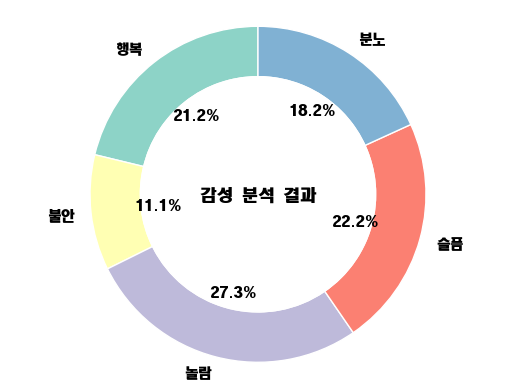

In [19]:
printvis(res)

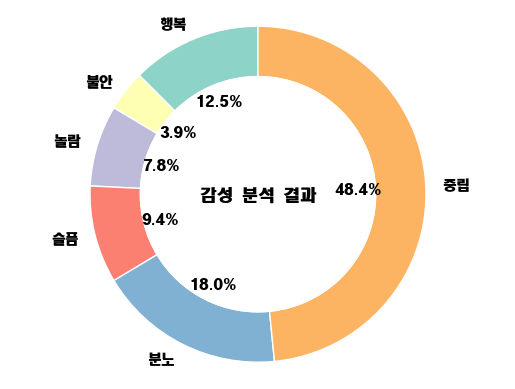

In [ ]:
import matplotlib.pyplot as plt

# 키와 값 리스트 추출
labels = list(res.keys())
sizes = list(res.values())

# 원형 그래프 그리기
fig1, ax1 = plt.subplots()

# 가운데 부분을 뚤린 원형으로 설정
wedgeprops = {'width': 0.3, 'edgecolor': 'white'}  # 가운데 부분 속성

# 원형 그래프 그리기
outer_colors = plt.cm.Set3(range(len(labels)))  # 바깥 부분 색상
inner_colors = ['white'] * len(labels)  # 가운데 부분 색상

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=outer_colors, wedgeprops=wedgeprops)

ax1.pie([1], radius=0.7, colors=inner_colors, wedgeprops=wedgeprops)  # 가운데 뚤린 원형 추가

# 가운데 부분에 텍스트 추가
plt.text(0, 0, '감성 분석 결과', ha='center', va='center', fontsize=12)

# 가운데 뚤린 원형 그래프 출력
plt.axis('equal')
plt.show()

In [7]:
import pandas as pd

sample1 = pd.read_csv('sentiment-analysis/data/output.csv', names=["book1"])  #index_col=0 하면 안됨
sample1.sample(n=8)

,book1
252,하는 말 끝엔 목이 메였다.
84,다리를 재게 놀려야만 쉴새없이 자기의 머리에 떠오르는 모든 근심과 걱정을 잊을 듯이.
83,집이 차차 멀어 갈수록 김첨지의 걸음에는 다시금 신이 나기 시작하였다.
0,운수 좋은날
248,“……”
2,이날이야말로 동소문 안에서 인력거꾼 노릇을 하는 김첨지에게는 오래간만에도 닥친 운...
90,"노동으로 하여 흐른 땀이 식어지자 굶주린 창자에서, 물 흐르는 옷에서 어슬어슬 한..."
63,하고 빙글빙글 웃는 차부의 얼굴에는 숨길 수 없는 기쁨이 넘쳐흘렀다.


In [ ]:
emos = ('행복','불안','놀람', '슬픔','분노','중립')
res = {'행복':0,'불안':0,'놀람':0, '슬픔':0,'분노':0,'중립':0}